# Basic Neural Networks 

(to compare pre-transfer learning)

In [1]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
#import xgboost as xgb     # extreme gradient boosting (XGB)
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

# Python file with supporting functions
import model_utils

2023-01-09 12:33:43.693218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
global_model_path = '/home/julias/MLEE-final-project/models/saved_models/global_models'

# Load Split Datasets and Create Versions for Experimentation

## Load Split Datasets

In [5]:
X_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X.nc').to_dataframe().dropna()
y_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y.nc').to_dataframe().dropna() 
X_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X_train.nc').to_dataframe().dropna() 
y_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y_train.nc').to_dataframe().dropna()
X_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X_test.nc').to_dataframe().dropna() 
y_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y_test.nc').to_dataframe().dropna() 

### Create Numpy Arrays for Original Data

In [6]:
X_original = X_df.to_numpy()         
y_original = y_df.to_numpy().ravel() 
X_train_original = X_train_df.to_numpy() 
y_train_original = y_train_df.to_numpy().ravel()
X_test_original = X_test_df.to_numpy()  
y_test_original = y_test_df.to_numpy().ravel()

## Create Normalized Dataframes

*Note: Done here, as opposed to in test/train split, so that I can save the original train/test datasets and later determine whether normalization led to improvement. (My group has not historically normalized data before training.)*

In [ ]:
#X_df_norm = (X_df - X_df.mean())/X_df.std() 
#y_df_norm = (y_df - y_df.mean())/y_df.std()
#X_train_df_norm = (X_train_df - X_train_df.mean())/X_train_df.std()
#y_train_df_norm = (y_train_df - y_train_df.mean())/y_train_df.std()
#X_test_df_norm = (X_test_df - X_test_df.mean())/X_test_df.std()
#y_test_df_norm = (y_test_df - y_test_df.mean())/y_test_df.std()

CHANGE METHOD TO BELOW
- This way, time and lat/lon conversions are not normalized
- Note that coordinates don't seem to be input into ML algorithms, so T0,T1,A,B,C are the inputs of time and space (as would want, don't want two forms of time and space input)

In [49]:
X_df_norm = X_df
y_df_norm = y_df
X_train_df_norm = X_train_df
y_train_df_norm = y_train_df
X_test_df_norm = X_test_df
y_test_df_norm = y_test_df

for df in X_df_norm, X_train_df_norm, X_test_df_norm:
    df.SSS = (df.SSS - df.SSS.mean())/df.SSS.std() 
    df.SST = (df.SST - df.SST.mean())/df.SST.std() 
    df.MLD = (df.MLD - df.MLD.mean())/df.MLD.std() 
    df.Chl = (df.Chl - df.Chl.mean())/df.Chl.std() 
    df.XCO2 = (df.XCO2 - df.XCO2.mean())/df.XCO2.std() 

for df in y_df_norm, y_train_df_norm, y_test_df_norm:
    df.pCO2 = (df.pCO2 - df.pCO2.mean())/df.pCO2.std() 

In [51]:
X_train_df_norm

SSS       SST       MLD       Chl      XCO2  \
xlon   ylat  time                                                           
-179.5 -77.5 1982-03-15 -0.265890 -1.488140 -0.692089  0.127524 -1.566749   
             1982-04-15 -0.102081 -1.720083 -0.150905  0.678477 -1.560679   
             1982-05-15  0.134703 -1.722093  2.425728 -0.357605 -1.554364   
             1982-06-15  0.190737 -1.725349  5.016110 -0.429174 -1.548060   
             1982-08-15  0.239313 -1.726704  5.787440 -0.451532 -1.535459   
...                           ...       ...       ...       ...       ...   
 179.5  62.5 1996-01-15 -1.523210 -1.704815 -0.663983 -0.328508 -0.471215   
             1998-12-15 -1.798378 -1.488968 -0.710701  1.133481 -0.165658   
             1999-12-15 -1.702374 -1.542382 -0.694616  0.787700 -0.080769   
             2010-02-15 -1.373927 -1.670204 -0.679423 -0.308730  1.031888   
             2011-12-15 -1.662782 -1.516546 -0.711923  0.733718  1.261811   

                               T0        T1         A         B         C  
xlon   ylat  time                                                          
-179.5 -77.5 1982-03-15  0.292600  0.956235 -0.976296 -0.001889  0.216431  
             1982-04-15 -0.234491  0.972118 -0.976296 -0.001889  0.216431  
             1982-05-15 -0.683919  0.729558 -0.976296 -0.001889  0.216431  
             1982-06-15 -0.959933  0.280231 -0.976296 -0.001889  0.216431  
             1982-08-15 -0.720667 -0.693281 -0.976296 -0.001889  0.216431  
...                           ...       ...       ...       ...       ...  
 179.5  62.5 1996-01-15  0.966848  0.255353  0.887011  0.004029  0.461731  
             1998-12-15  0.962309 -0.271958  0.887011  0.004029  0.461731  
             1999-12-15  0.962309 -0.271958  0.887011  0.004029  0.461731  
             2010-02-15  0.702527  0.711657  0.887011  0.004029  0.461731  
             2011-12-15  0.962309 -0.271958  0.887011  0.004029  0.461731  

[11865574 rows x 10 columns]

## Create Numpy Arrays 

In [ ]:
X_n = X_df_norm.to_numpy()         
y_n = y_df_norm.to_numpy().ravel() 
X_train_n = X_train_df_norm.to_numpy()
y_train_n = y_train_df_norm.to_numpy().ravel()
X_test_n = X_test_df_norm.to_numpy() 
y_test_n = y_test_df_norm.to_numpy().ravel()

# Preliminary NN Model using Normalized Input

## Build NN Model

In [ ]:
# NOTE that number of input layer neurons must correspond to number of predictor variables

In [ ]:
# set hyperparameters
n_neuron       = 32 #64
activation     = 'LeakyReLU'
num_epochs     = 10 #50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [ ]:
NN_model = Sequential()

NN_model.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_original.shape[1],))) #  the 1st hidden layer 
NN_model.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
NN_model.add(Dense(1, name='output_layer', activation='linear')) # the output layer


NN_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [ ]:
NN_model.summary()

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = NN_model.fit(X_train_df_norm, y_train_df_norm, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

## Initial Checks

In [ ]:
model_utils.plot_history(history)

Validation loss does jump around and is generally higher than the training loss, indicating that the model isn't generalizing well

## Save NN Model

In [ ]:
# after training, save:
NN_model.save(os.path.join(global_model_path,'NN_model_prelim_global.h5'))

## Test NN Model

In [ ]:
# then reload before start working with test data
NN_prelim_model = load_model(os.path.join(global_model_path,'NN_model_prelim_global.h5'))

In [ ]:
y_pred = NN_prelim_model.predict(X_test_df_norm)
mse = mean_squared_error(y_test_df_norm, y_pred)
print("MSE: %.2f" % mse)

In [ ]:
x_ax = range(len(y_test_df_norm))
plt.plot(x_ax, y_test_df_norm, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

In [ ]:
y_test_df_norm['y_pred']= y_pred
save_prelim_y_pred = y_test_df_norm
save_prelim_y_pred.to_csv('/home/julias/MLEE-final-project/models/saved_models/global_models/save_prelim_y_pred.csv')

# NN Model Optimization: First Run

## Build NN Model

In [9]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [10]:
NN_model1 = Sequential()

NN_model1.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_df_norm.shape[1],))) #  the 1st hidden layer 
NN_model1.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
NN_model1.add(Dense(n_neuron, name='hidden_layer_3', activation=activation)) # the 3rd hidden layer
NN_model1.add(Dense(1, name='output_layer', activation='linear')) # the output layer


NN_model1.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [11]:
NN_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                704       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [12]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


history1 = NN_model1.fit(X_train_df_norm, y_train_df_norm, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
148320/148320 [==============================] - 196s 1ms/step - loss: 0.0777 - val_loss: 0.2947
Epoch 2/50
148320/148320 [==============================] - 192s 1ms/step - loss: 0.0600 - val_loss: 0.3153
Epoch 3/50
148320/148320 [==============================] - 193s 1ms/step - loss: 0.0559 - val_loss: 0.3544
Epoch 4/50
148320/148320 [==============================] - 191s 1ms/step - loss: 0.0537 - val_loss: 0.3481
Epoch 5/50
148320/148320 [==============================] - 191s 1ms/step - loss: 0.0522 - val_loss: 0.2984
Epoch 6/50
148320/148320 [==============================] - 193s 1ms/step - loss: 0.0512 - val_loss: 0.2973
Epoch 7/50
148320/148320 [==============================] - 195s 1ms/step - loss: 0.0504 - val_loss: 0.3473
Epoch 8/50
148320/148320 [==============================] - 194s 1ms/step - loss: 0.0498 - val_loss: 0.3043
Epoch 9/50
148320/148320 [==============================] - 197s 1ms/step - loss: 0.0492 - val_loss: 0.3321
Epoch 10/50
148320/148320 [=

## Initial Checks

Can see that validation loss reaches minimums and jumps around, plot to see if trend indicates overfitting

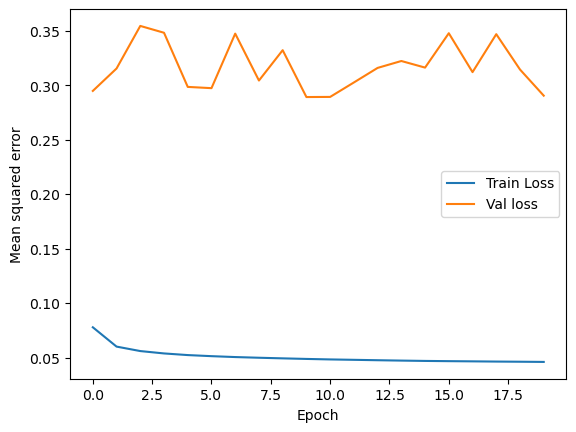

In [14]:
model_utils.plot_history(history1)

While the training loss goes down substantially, the validation loss does not show the same trend. Instead, it remains (relatively) high and jumps around.
- Completely fine, just signals that hyperparameter tuning will be needed (as expected)

## Save NN Model

In [13]:
# after training, save:
NN_model1.save(os.path.join(global_model_path,'NN_model1.h5'))

## Test NN Model

In [15]:
NN_model1_loaded = load_model(os.path.join(global_model_path,'NN_model1.h5'))

In [16]:
y_pred1 = NN_model1_loaded.predict(X_test_df_norm)
mse = mean_squared_error(y_test_df_norm, y_pred1)
print("MSE: %.2f" % mse)

92702/92702 [==============================] - 65s 700us/step
MSE: 0.10


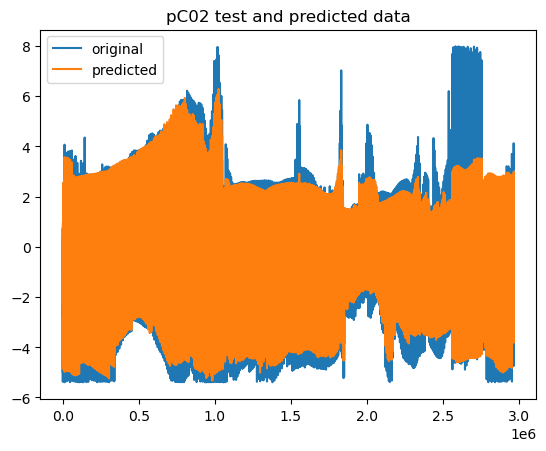

In [17]:
x_ax = range(len(y_test_df_norm))
plt.plot(x_ax, y_test_df_norm, label="original")
plt.plot(x_ax, y_pred1, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

# NN Model Optimization: Second Run

## Build NN Model

- Goal: improve validation loss by increasing val split to 70/30 and increasing learning rate to 0.2 (and increase patience back up a bit, to 15)
- Started run, but training loss is still starting so low and validation staying high. Maybe overfitting to training set, simplify model.
- Simplified version performing even worse, again stopped model.

In [22]:
# set hyperparameters
n_neuron       = 32
activation     = 'LeakyReLU'
num_epochs     = 20
learning_rate  = 0.002
minibatch_size = 64
model_num      = 1

In [23]:
NN_model2 = Sequential()

NN_model2.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_df_norm.shape[1],))) #  the 1st hidden layer 
NN_model2.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
#NN_model2.add(Dense(n_neuron, name='hidden_layer_3', activation=activation)) # the 3rd hidden layer
NN_model2.add(Dense(1, name='output_layer', activation='linear')) # the output layer


NN_model2.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [24]:
NN_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 32)                352       
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [27]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


history2 = NN_model2.fit(X_train_df_norm, y_train_df_norm, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.3, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/20
129780/129780 [==============================] - 162s 1ms/step - loss: 0.0941 - val_loss: 0.3919
Epoch 2/20
129780/129780 [==============================] - 162s 1ms/step - loss: 0.0852 - val_loss: 0.3711
Epoch 3/20
129780/129780 [==============================] - 166s 1ms/step - loss: 0.0821 - val_loss: 0.3952
Epoch 4/20
129780/129780 [==============================] - 161s 1ms/step - loss: 0.0804 - val_loss: 0.4009
Epoch 5/20
129780/129780 [==============================] - 165s 1ms/step - loss: 0.0791 - val_loss: 0.3898
Epoch 6/20
129780/129780 [==============================] - 164s 1ms/step - loss: 0.0781 - val_loss: 0.4776
Epoch 7/20
  5482/129780 [>.............................] - ETA: 2:00 - loss: 0.0779

KeyboardInterrupt: 

# NN Model Optimization: Third Run

## Build NN Model

In [28]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.0015
minibatch_size = 32
model_num      = 1

In [32]:
NN_model3 = Sequential()

NN_model3.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_df_norm.shape[1],))) #  the 1st hidden layer 
NN_model3.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
NN_model3.add(Dense(n_neuron, name='hidden_layer_3', activation=activation)) # the 3rd hidden layer
NN_model3.add(Dense(1, name='output_layer', activation='linear')) # the output layer


NN_model3.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [33]:
NN_model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                704       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


history3 = NN_model3.fit(X_train_df_norm, y_train_df_norm, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

## Initial Checks

Can see that validation loss reaches minimums and jumps around, plot to see if trend indicates overfitting

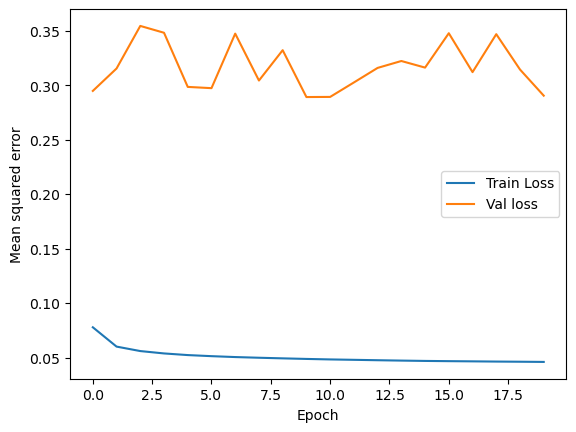

In [14]:
model_utils.plot_history(history2)

While the training loss goes down substantially, the validation loss does not show the same trend. Instead, it remains (relatively) high and jumps around.
- Completely fine, just signals that hyperparameter tuning will be needed (as expected)

## Save NN Model

In [ ]:
# after training, save:
NN_model2.save(os.path.join(global_model_path,'NN_model2.h5'))

## Test NN Model

In [15]:
NN_model1_loaded = load_model(os.path.join(global_model_path,'NN_model1.h5'))

In [16]:
y_pred1 = NN_model1_loaded.predict(X_test_df_norm)
mse = mean_squared_error(y_test_df_norm, y_pred1)
print("MSE: %.2f" % mse)

92702/92702 [==============================] - 65s 700us/step
MSE: 0.10


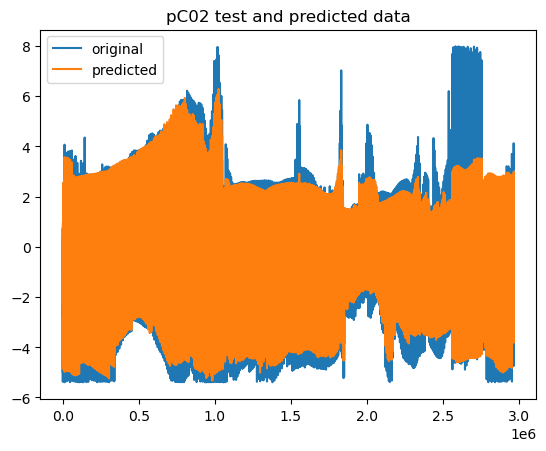

In [17]:
x_ax = range(len(y_test_df_norm))
plt.plot(x_ax, y_test_df_norm, label="original")
plt.plot(x_ax, y_pred1, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

# Select Approach & Parameters

## Approach

- Based on preliminary experimentation, will train the NN model on normalized data, as is standard machine learning practice
- Comparison completed above for group reference, as data has not historically been normalized prior to training

## Parameters

Experimentation with hyperparameters completed below

### Experiment with NN Model

In [ ]:
# set hyperparameters
n_neuron       = 100
activation     = 'LeakyReLU'
num_epochs     = 100
learning_rate  = 0.002
minibatch_size = 64
model_num      = 1
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
NN_model_exp = Sequential()

NN_model_exp.add(Dense(n_neuron,  activation=activation, name='hidden_layer_1', input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
NN_model_exp.add(Dense(n_neuron,  activation=activation, name='hidden_layer_2')) # the 2nd hidden layer
NN_model_exp.add(Dense(n_neuron,  activation=activation, name='hidden_layer_3')) # the 3rd hidden layer
NN_model_exp.add(Dense(1,  activation='linear', name='output_layer')) # the output layer


NN_model_exp.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [ ]:
NN_model_exp.summary()

### Train Experimental NN Model

In [ ]:
history_exp = NN_model_exp.fit(X_train, y_train, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

### Initial Checks on Experimental NN Model

In [ ]:
model_utils.plot_history(history_exp)

In [ ]:
y_pred_exp = NN_model_exp.predict(X_test)
mse = mean_squared_error(y_test, y_pred_exp)
print("MSE: %.2f" % mse)

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_exp, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

### Save Best Experimental NN Model as First of NN Below

In [ ]:
# after training, save:
NN_model_exp.save(os.path.join(global_model_path,'NN_model1.h5'))

# Five Identical NN Models 

## NN Model 1

In [ ]:
NN_model1 = load_model(os.path.join(global_model_path,'NN_model1.h5'))

## NN Model 2

## NN Model 3

## NN Model 4

## NN Model 5